# Heading prediction 


## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
1. [Predict](#Predict)
1. [Extensions](#Extensions)

---

## Background
This notebook illustrates how one can use SageMaker's algorithms for solving applications which require `linear models` for prediction.
* Basic setup for using SageMaker.
* converting datasets to protobuf format used by the Amazon SageMaker algorithms and uploading to S3. 
* Training SageMaker's linear learner on the data set.
* Hosting the trained model.
* Scoring using the trained model.



---

## Setup

Let's start by specifying:

* The SageMaker role arn used to give learning and hosting access to your data. The snippet below will use the same role used by your SageMaker notebook instance, if you're using other.  Otherwise, specify the full ARN of a role with the SageMakerFullAccess policy attached.
* The S3 bucket that you want to use for training and storing model objects.

Now we'll import the Python libraries we'll need.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import time
import json
import sagemaker.amazon.common as smac
import os
import boto3
import re
import sagemaker
from os.path import join
from sagemaker.amazon.amazon_estimator import get_image_uri
from sklearn.preprocessing import StandardScaler

In [56]:
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
bucket = 'virtual-regatta-ml'

prefix = 'linear-learner' # place to upload training files within the bucket

---
## Data


In [57]:
data = pd.read_csv('../all-in-one.csv')

# This column will be predicted using regression
data = data.drop(columns=['cos_boat_angle'])

# The column to predict has to be in last position
df_reordered = data[['boat_speed','angle_of_attack','wind_speed','sin_target_angle', 'cos_target_angle','sin_boat_angle']]

# Binary classifier only accepts 0 and 1
#df_reordered['sign_sin_target_angle'] = df_reordered['sign_sin_target_angle'].map({-1:0, 1:1})
#df_reordered['sign_sin_boat_angle'] = df_reordered['sign_sin_boat_angle'].map({-1:0, 1:1})

df_reordered.describe()

,boat_speed,angle_of_attack,wind_speed,sin_target_angle,cos_target_angle,sin_boat_angle
count,3423.000000,3423.000000,3423.000000,3423.000000,3423.000000,3423.000000
mean,6.084980,13.651101,9.279375,0.203516,-0.183504,0.193281
std,2.326619,111.365486,5.466267,0.711735,0.647002,0.722185
min,0.000000,-177.061360,2.000000,-1.000000,-0.999999,-1.000000
25%,4.189240,-119.849030,5.058210,-0.448450,-0.873379,-0.602422
50%,5.896690,44.954220,7.749050,0.270130,-0.273917,0.380570
75%,7.663520,125.254900,11.392670,0.956561,0.302948,0.893163
max,9.954010,160.387210,21.077130,1.000000,0.996583,1.000000


## Create Features and Labels
#### Split the data into 80% training, 10% validation and 10% testing.

Now, we'll convert the datasets to the recordIO-wrapped protobuf format used by the Amazon SageMaker algorithms, and then upload this data to S3.  We'll start with training data.

In [58]:
def save_train_and_validation_data_to_s3(bucket, test_name, data) :
    rand_split = np.random.rand(len(data))
    train_list = rand_split < 0.8
    val_list = (rand_split >= 0.8) & (rand_split < 0.9)
    test_list = rand_split >= 0.9

    data_train = data[train_list]
    data_val = data[val_list]
    data_test = data[test_list]

    train_y = data_train.iloc[:,-1].to_numpy();
    train_X = data_train.iloc[:,:-1].to_numpy();
    print(train_X)
    print(train_y)

    val_y = data_val.iloc[:,-1].to_numpy();
    val_X = data_val.iloc[:,:-1].to_numpy();

    test_y = data_test.iloc[:,-1].to_numpy();
    test_X = data_test.iloc[:,:-1].to_numpy();
    train_file = 'linear_train.data'

    f = io.BytesIO()
    smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
    f.seek(0)
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, test_name, 'train', train_file)).upload_fileobj(f)
    validation_file = 'linear_validation.data'
    
    f = io.BytesIO()
    smac.write_numpy_to_dense_tensor(f, val_X.astype('float32'), val_y.astype('float32'))
    f.seek(0)
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, test_name,'validation', validation_file)).upload_fileobj(f)
    return (test_X, test_y)

In [59]:
test_name = 'default'

test_X, test_y = save_train_and_validation_data_to_s3(bucket, test_name, df_reordered)

[[ 7.73236000e+00 -1.23944700e+02  9.43467000e+00 -8.64219539e-01
  -5.03114886e-01]
 [ 7.73236000e+00 -1.23944700e+02  9.43467000e+00 -8.93119265e-01
  -4.49819941e-01]
 [ 7.81913000e+00 -1.24944700e+02  9.66396000e+00 -8.56914548e-01
  -5.15458493e-01]
 ...
 [ 3.03315000e+00  1.30213000e+02  3.14956000e+00  1.26885045e-01
  -9.91917429e-01]
 [ 2.95132000e+00  1.35226500e+02  3.25623000e+00 -4.49673522e-01
  -8.93192993e-01]
 [ 2.99092000e+00  1.35226500e+02  3.29993000e+00 -7.00941324e-01
  -7.13218943e-01]]
[-0.86705627 -0.86705627 -0.85306084 ... -0.12063618 -0.38772506
 -0.42823483]


---
## Train

Now we can begin to specify our linear model.  Amazon SageMaker's Linear Learner actually fits many models in parallel, each with slightly different hyperparameters, and then returns the one with the best fit.  This functionality is automatically enabled.  We can influence this using parameters like:

- `num_models` to increase to total number of models run.  The specified parameters will always be one of those models, but the algorithm also chooses models with nearby parameter values in order to find a solution nearby that may be more optimal.  In this case, we're going to use the max of 32.
- `loss` which controls how we penalize mistakes in our model estimates.  For this case, let's use absolute loss as we haven't spent much time cleaning the data, and absolute loss will be less sensitive to outliers.
- `wd` or `l1` which control regularization.  Regularization can prevent model overfitting by preventing our estimates from becoming too finely tuned to the training data, which can actually hurt generalizability.  In this case, we'll leave these parameters as their default "auto" though.

In [60]:
def launch_training(sm, container, bucket, prefix, test_number, instance_type, hyperparameters):

    linear_job = 'VR-sign-sin-regression-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

    print("Job name is:", linear_job)

    linear_training_params = {
        "RoleArn": role,
        "TrainingJobName": linear_job,
        "AlgorithmSpecification": {
            "TrainingImage": container,
            "TrainingInputMode": "File"
        },
        "ResourceConfig": {
            "InstanceCount": 1,
            "InstanceType": instance_type,
            "VolumeSizeInGB": 1
        },
        "InputDataConfig": [
            {
                "ChannelName": "train",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "S3Prefix",
                        "S3Uri": "s3://{}/{}/{}/train/".format(bucket, prefix, test_number),
                        "S3DataDistributionType": "ShardedByS3Key"
                    }
                },
                "CompressionType": "None",
                "RecordWrapperType": "None"
            },
            {
                "ChannelName": "validation",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "S3Prefix",
                        "S3Uri": "s3://{}/{}/{}/validation/".format(bucket, prefix, test_number),
                        "S3DataDistributionType": "FullyReplicated"
                    }
                },
                "CompressionType": "None",
                "RecordWrapperType": "None"
            }

        ],
        "OutputDataConfig": {
            "S3OutputPath": "s3://{}/{}/{}/".format(bucket, prefix, test_number)
        },
        "HyperParameters": hyperparameters,
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 60 * 60
        }
    }

    sm.create_training_job(**linear_training_params)

    status = sm.describe_training_job(TrainingJobName=linear_job)['TrainingJobStatus']
    print(status)
    sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=linear_job)
    print("training done")
    return linear_job
    if status == 'Failed':
        message = sm.describe_training_job(TrainingJobName=linear_job)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Training job failed')

### Specify container images used for training and hosting SageMaker's linear-learner

In [61]:
# See 'Algorithms Provided by Amazon SageMaker: Common Parameters' in the SageMaker documentation for an explanation of these values.
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Now let's kick off our training job in SageMaker's distributed, managed training, using the parameters we just created.  Because training is managed, we don't have to wait for our job to finish to continue, but for this case, let's use boto3's 'training_job_completed_or_stopped' waiter so we can ensure that the job has been started.

In [62]:
region = boto3.Session().region_name
sm = boto3.client('sagemaker')
hyperparameters = {
        "feature_dim": "5",
        "mini_batch_size": "64",
        "predictor_type": "regressor",
        "epochs": "100",
        "num_models": "32",
        "loss": "absolute_loss"
    }
instance_type = "ml.m5.large"

linear_job = launch_training(sm, container, bucket, prefix, test_name, instance_type, hyperparameters)

Job name is: VR-sign-sin-regression-2020-09-25-14-48-48
InProgress
training done


---
## Host

Now that we've trained the linear algorithm on our data, let's setup a model which can later be hosted.  We will:
1. Point to the scoring container
1. Point to the model.tar.gz that came from training
1. Create the hosting model

Once we've setup a model, we can configure what our hosting endpoints should be.  Here we specify:
1. EC2 instance type to use for hosting
1. Initial number of instances
1. Our hosting model name

Now that we've specified how our endpoint should be configured, we can create them.  This can be done in the background, but for now let's run a loop that updates us on the status of the endpoints so that we know when they are ready for use.

In [63]:
def launch_endpoint(container, linear_job, role, instance_type) :

    linear_hosting_container = {
        'Image': container,
        'ModelDataUrl': sm.describe_training_job(TrainingJobName=linear_job)['ModelArtifacts']['S3ModelArtifacts']
    }

    create_model_response = sm.create_model(
    ModelName=linear_job,
        ExecutionRoleArn=role,
        PrimaryContainer=linear_hosting_container)

    print(create_model_response['ModelArn'])

    linear_endpoint_config = 'VR-sin-regression-endpoint-config-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
    print(linear_endpoint_config)
    create_endpoint_config_response = sm.create_endpoint_config(
        EndpointConfigName=linear_endpoint_config,
        ProductionVariants=[{
            'InstanceType': instance_type,
            'InitialInstanceCount': 1,
            'ModelName': linear_job,
            'VariantName': 'AllTraffic'}])

    print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

    linear_endpoint = 'VR-sin-regression-endpoint-' + time.strftime("%Y%m%d%H%M", time.gmtime())
    print(linear_endpoint)
    create_endpoint_response = sm.create_endpoint(
        EndpointName=linear_endpoint,
        EndpointConfigName=linear_endpoint_config)
    print(create_endpoint_response['EndpointArn'])

    resp = sm.describe_endpoint(EndpointName=linear_endpoint)
    status = resp['EndpointStatus']
    print("Status: " + status)

    sm.get_waiter('endpoint_in_service').wait(EndpointName=linear_endpoint)

    resp = sm.describe_endpoint(EndpointName=linear_endpoint)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Status: " + status)
    return linear_endpoint
    if status != 'InService':
        raise Exception('Endpoint creation did not succeed')

In [64]:
%%time

instance_type = 'ml.t2.medium'

linear_endpoint = launch_endpoint(container, linear_job, role, instance_type)

arn:aws:sagemaker:eu-west-2:281633979087:model/vr-sign-sin-regression-2020-09-25-14-48-48
VR-sin-regression-endpoint-config-2020-09-25-14-52-49
Endpoint Config Arn: arn:aws:sagemaker:eu-west-2:281633979087:endpoint-config/vr-sin-regression-endpoint-config-2020-09-25-14-52-49
VR-sin-regression-endpoint-202009251452
arn:aws:sagemaker:eu-west-2:281633979087:endpoint/vr-sin-regression-endpoint-202009251452
Status: Creating
Arn: arn:aws:sagemaker:eu-west-2:281633979087:endpoint/vr-sin-regression-endpoint-202009251452
Status: InService
CPU times: user 275 ms, sys: 8.37 ms, total: 283 ms
Wall time: 8min 32s


## Predict
### Predict on Test Data

Now that we have our hosted endpoint, we can generate statistical predictions from it.  Let's predict on our test dataset to understand how accurate our model is.

There are many metrics to measure classification accuracy.  Common examples include include:
- Precision
- Recall
- F1 measure
- Area under the ROC curve - AUC
- Total Classification Accuracy 
- Mean Absolute Error

For our example, we'll keep things simple and use total classification accuracy as our metric of choice. We will also evaluate  Mean Absolute  Error (MAE) as the linear-learner has been optimized using this metric, not necessarily because it is a relevant metric from an application point of view. We'll compare the performance of the linear-learner against a naive benchmark prediction which uses majority class observed in the training data set for prediction on the test data.




### Function to convert an array to a csv

In [65]:
def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()

Next, we'll invoke the endpoint to get predictions.

In [66]:
runtime= boto3.client('runtime.sagemaker')

payload = np2csv(test_X)
response = runtime.invoke_endpoint(EndpointName=linear_endpoint,
                                   ContentType='text/csv',
                                   Body=payload)
result = json.loads(response['Body'].read().decode())
test_pred = np.array([r['score'] for r in result['predictions']])

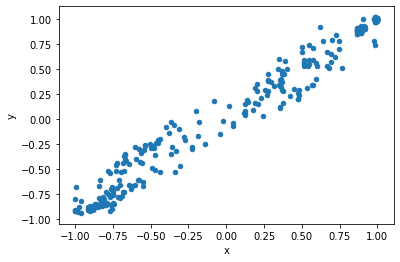

In [72]:
test = pd.DataFrame(columns=['x', 'y'])

test.x = test_y
test.y = test_pred

test.plot.scatter(x='x',y='y')

Let's compare linear learner based mean absolute prediction errors from a baseline prediction which uses majority class to predict every instance.

In [68]:
test_mae_linear = np.mean(np.abs(test_y - test_pred))

print("Test MAE Linear:", round(test_mae_linear,3))

Test MAE Linear: 0.074


In [73]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_y, test_pred)
print("Test MSE:", round(mse,3))

Test MSE: 0.013


---
## Extensions

- Our linear model does a good job of predicting breast cancer and has an overall accuracy of close to 92%. We can re-run the model with different values of the hyper-parameters, loss functions etc and see if we get improved prediction. Re-running the model with further tweaks to these hyperparameters may provide more accurate out-of-sample predictions.
- We also did not do much feature engineering. We can create additional features by considering cross-product/intreaction of multiple features, squaring or raising higher powers of the features to induce non-linear effects, etc. If we expand the features using non-linear terms and interactions, we can then tweak the regulaization parameter to optimize the expanded model and hence generate improved forecasts.
- As a further extension, we can use many of non-linear models available through SageMaker such as XGBoost, MXNet etc.
